## 🧠 MSLesSeg Dataset Overview

As part of this competition, participants were provided with the **MSLesSeg Dataset** — a **comprehensively annotated, multi-modal MRI dataset** designed for advancing **lesion segmentation** research in medical imaging.

### 📊 Dataset Composition
- **Total Patients:** 75 (48 women, 27 men)  
- **Age Range:** 18–59 years (Mean: 37 ± 10.3 years)  
- **Longitudinal Timepoints:**  
  - 50 patients with 1 timepoint  
  - 15 patients with 2 timepoints  
  - 5 patients with 3 timepoints  
  - 5 patients with 4 timepoints  
- **Time Interval Between Scans:** ~1.27 ± 0.62 years  
- **Total MRI Series:** 115

### 🧬 Imaging Modalities
Each timepoint includes **three core MRI modalities**:
- **T1-weighted (T1-w)**
- **T2-weighted (T2-w)**
- **FLAIR (Fluid-Attenuated Inversion Recovery)**

### 🧑‍⚕️ Expert Annotation
- Lesions were **manually annotated** by clinical experts.
- **FLAIR sequences** were the primary reference for lesion labeling.
- **T1-w and T2-w** scans supported **multi-contrast lesion characterization**.

### 🧪 Dataset Splits
- **Training Set:** 53 scans  
- **Test Set:** 22 scans  

### ✅ Ethical Compliance
- **Ethical approval** was obtained from the corresponding Hospital Ethics Committee.
- **Informed consent** was acquired from all participating patients.

---

# The Experiment

Below is the code used for the:

1) Preprocessing of the ***Brain MRI*** scans
2) Definition of Dataset, Dataloader and LihgtningDataModule classes
3) ***SegFormer3D*** architecture
4) ***PyTorch Lightning*** Trainer
5) Training & Evaluation
6) Model Exaplainability with the post-hoc method ***GradCam++***

---

## 🛠️ Preprocessing & Annotation Workflow

The MSLesSeg dataset underwent a **comprehensive preprocessing pipeline** and **expert-driven manual annotation** to ensure **standardization** and **label quality** for downstream MS lesion segmentation tasks.

### 🧼 Preprocessing Pipeline
1. **Anonymization** of all MRI scans to protect patient privacy.
2. **DICOM to NIfTI conversion**, leveraging NIfTI's wide adoption in neuroimaging.
3. **Co-registration to the MNI152 1mm³ isotropic template** using **FLIRT** (FMRIB’s Linear Image Registration Tool), ensuring all scans are aligned to a **common anatomical space**.
4. **Brain extraction** via **BET** (Brain Extraction Tool) to remove non-brain tissues and isolate relevant structures.

This pipeline guarantees that all images are **standardized** and **aligned**, which is critical for **automated MS lesion segmentation algorithms**.

---

### 🖋️ Ground-Truth Annotation Protocol
- Lesions were **manually segmented** on the **FLAIR modality** for each patient and timepoint.
- **T1-w and T2-w** modalities were used to **cross-validate ambiguous cases**.
- Annotation was conducted by a **trained junior rater**, under supervision of:
  - A **senior neuroradiologist**
  - A **senior neurologist**
- Annotation sessions included:
  - Multiple **training meetings** to establish a **consistent segmentation strategy**
  - Use of **JIM9** — a high-end tool for **medical image segmentation and analysis**
  - Regular **expert validation checkpoints** to ensure consistency and accuracy

The final masks, reviewed and approved by senior experts, are considered the **gold-standard ground truth**.

---

## 🧾 Key Annotation Highlights
- **Independent segmentation** for each patient/timepoint to avoid bias
- Conducted on **FLAIR scans registered to MNI space**
- **Validated ground-truth masks** ready for training and evaluation

---


# Visualizing the Brain MRI Scans

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

def load_nifti(file_path):
    nii = nib.load(file_path)
    return nii.get_fdata()

def get_middle_slice(volume):
    z = volume.shape[2] // 2
    return volume[:, :, z]

def plot_modalities_with_segmentation(flair_path, t1_path, t2_path, seg_path):
    # Load volumes
    flair = load_nifti(flair_path)
    t1 = load_nifti(t1_path)
    t2 = load_nifti(t2_path)
    seg = load_nifti(seg_path)

    # Normalize intensities for better visualization
    def normalize(img):
        img = img.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        return img

    flair_norm = normalize(flair)
    t1_norm = normalize(t1)
    t2_norm = normalize(t2)

    # Get middle slices
    flair_slice = get_middle_slice(flair_norm)
    t1_slice = get_middle_slice(t1_norm)
    t2_slice = get_middle_slice(t2_norm)
    seg_slice = get_middle_slice(seg)

    modalities = [flair_slice, t1_slice, t2_slice]
    names = ["FLAIR", "T1", "T2"]

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    for i in range(3):
        # Row 1: original modality
        axs[0, i].imshow(modalities[i], cmap='gray')
        axs[0, i].set_title(f"{names[i]} - Middle Slice")
        axs[0, i].axis('off')

        # Row 2: overlay with segmentation mask
        axs[1, i].imshow(modalities[i], cmap='gray')
        axs[1, i].imshow(seg_slice, cmap='Reds', alpha=0.4)  # overlay
        axs[1, i].set_title(f"{names[i]} + Segmentation")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

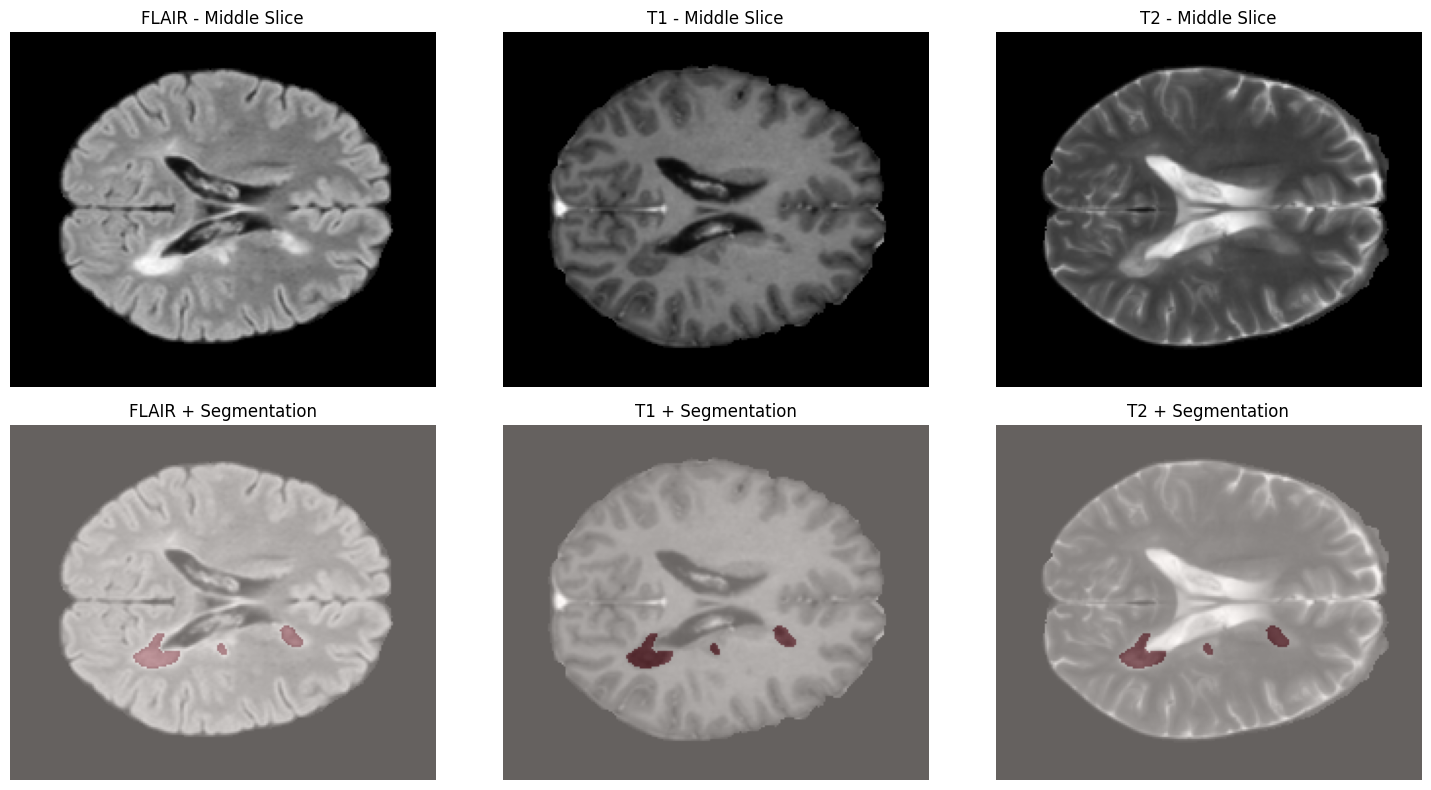

In [2]:
plot_modalities_with_segmentation(
    flair_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_flair.nii.gz",
    t1_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_t1.nii.gz",
    t2_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_t2.nii.gz",
    seg_path="../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_seg.nii.gz"
)

---

As can be seen by the previous illustrations, the visualization of the data can be quite tricky, this is why developing reliable and high-quality ***Deep Learning*** architectures for ***Medical Imaging*** is paramount for the progress of the field in the medical realm

---

The following code shows all the details stored in the ***.nii.gz*** files of the ***Brain MRI*** scans

---

In [3]:
import nibabel as nib
import os
import numpy as np

def inspect_nifti_file(nii_path):
    if not os.path.exists(nii_path):
        print(f"File not found: {nii_path}")
        return

    img = nib.load(nii_path)
    data = img.get_fdata()
    affine = img.affine
    header = img.header

    print(f"Shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Voxel dimensions (zoom): {header.get_zooms()}")
    print(f"Affine matrix:\n{affine}")
    print(f"Min intensity: {np.min(data):.2f}")
    print(f"Max intensity: {np.max(data):.2f}")

In [4]:
for i in range(0, 10): 
    nii_path = f"../data/01-Pre-Processed-Data/train/MSLS_00{i}/MSLS_00{i}_flair.nii.gz"
    inspect_nifti_file(nii_path)
    print("\n\n\n")

Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity: 269.00




Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity: 651.00




Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity: 590.00




Shape: (182, 218, 182)
Data type: float64
Voxel dimensions (zoom): (1.0, 1.0, 1.0)
Affine matrix:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Min intensity: 0.00
Max intensity:

---

The following code shows that despite aligning the ***Brain MRI*** scans to the ***MNI152*** space with the ***FLIRT*** tool, they are physically stored in the ***LAS*** orientation

In order to guarantee compatibility with the model, and for better processing, they will be re-aligned to the ***RAS*** orientation

---

In [5]:
# Get the orientation codes of the Brain MRI data
import nibabel as nib
from nibabel.orientations import aff2axcodes

# Load your NIfTI file
img = nib.load("../data/01-Pre-Processed-Data/train/MSLS_000/MSLS_000_flair.nii.gz")

# Get the affine matrix
affine = img.affine

# Get the orientation codes (e.g., RAS, LAS, LPI, etc.)
orientation = aff2axcodes(affine)

print(f"Image orientation: {orientation}")

Image orientation: ('L', 'A', 'S')


---

## Dataset Preprocessing

In this section we preprocess the data further in order to make it more ***friendly*** for the ***Deep Learning*** architecture to process, by applying:

1) ***Z-Scoring*** to align the intensity values of all scans
2) ***RAS re-orientation*** which is frequently used in ***Medical Imaging*** applications
3) ***Transverse Axis Swapping*** which is also commonly used in the same real of ***Computer Vision***

---

In [6]:
import os
import torch
import nibabel as nib
import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.transform import resize
from pathlib import Path
from tqdm.notebook import tqdm

In [7]:
# Load up the .nii.gz dataset of Brain MRI scans - for the Multiple Sclerosis Lesion Segmentation Dataset
def load_nifti(file_path):
    return nib.load(file_path).get_fdata()

In [8]:
import numpy as np
import torch
import nibabel as nib
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

class Preprocessor:
    def __init__(self):
        pass

    def normalize(self, x: np.ndarray) -> np.ndarray:
        """
        Min-max normalization to [0, 1]
        This method reshapes the input array to 2D, applies normalization, and reshapes back.
        """
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Flatten the data to 2D (H*W*D, 1)
        original_shape = x.shape
        x_flat = x.reshape(-1, x.shape[-1])  # Reshape to (H*W*D, 1)
        
        # Apply normalization
        normalized_1D_array = scaler.fit_transform(x_flat)
        
        # Reshape back to the original data shape
        normalized_data = normalized_1D_array.reshape(original_shape)
        return normalized_data

    def load_nifti(self, filepath: Path):
        """ Load the .nii.gz file using nibabel and return the data and affine """
        img = nib.load(str(filepath))
        data = img.get_fdata()
        affine = img.affine
        return data, affine

    def preprocess_modality(self, data_fp: str, is_label: bool = False) -> np.ndarray:
        """
        Apply preprocess stage to the modality
        data_fp: directory to the modality
        is_label: whether it's a label (segmentation mask)
        """
        # Load data using nibabel
        data, affine = self.load_nifti(data_fp)

        # For labels (segmentation masks), do not normalize
        if is_label:
            # Binary mask does not need to be float64! For saving storage purposes!
            data = data.astype(np.uint8)
            
            # If data is 3D (D, H, W), swap axes for transverse plane (D, H, W) -> (W, D, H)
            if data.ndim == 3:
                data = data.swapaxes(1, 2)  # Swap H and W dimensions
            # Apply one-hot encoding if needed (for multi-class segmentation)
            # data = ConvertToMultiChannelBasedOnBratsClasses()(data)  # Optional, if needed

        else:
            # Normalize the image (for modalities like flair, t1, t2)
            data = self.normalize(data)

            # Add channel dimension (1, D, H, W)
            data = data[np.newaxis, ...]

        # For reorienting to RAS coordinate system, we need to apply affine matrix
        # Since we are now using nibabel, affine is already handled with the image
        data = self.reorient_to_ras(data, affine)

        return data

    def reorient_to_ras(self, data: np.ndarray, affine: np.ndarray) -> np.ndarray:
        """ Reorient the image to RAS using the affine matrix """
        # Here you would use the affine matrix to adjust the orientation to RAS.
        # Since nibabel loads the data with its affine, this is typically not necessary
        # unless you need to do some custom reorientation.
        # For now, we are just passing through the data (as nibabel handles this well).
        return data  # If you need to reorient further, apply affine transformations here.

    def preprocess_case(self, input_dir: Path, output_dir: Path, case_id: str):
        modalities = ['flair', 't1', 't2']
        stacked_modalities = []

        # Process each modality (flair, t1, t2)
        for mod in modalities:
            path = input_dir / f"{case_id}_{mod}.nii.gz"
            preprocessed = self.preprocess_modality(path, is_label=False)
            stacked_modalities.append(preprocessed)  # Collect modality data

        # Stack the modalities into a single tensor with shape (C, D, H, W)
        stacked_tensor = np.concatenate(stacked_modalities, axis=0)
        input_tensor = torch.tensor(stacked_tensor, dtype=torch.float32)

        # Process the segmentation mask (label)
        seg_path = input_dir / f"{case_id}_seg.nii.gz"
        seg_data = self.preprocess_modality(seg_path, is_label=True)
        # Expand the dimension to add the channel dim
        seg_data = np.expand_dims(seg_data, axis=0)
        # Convert the segmentation mask into a PyTorch Tensor
        seg_tensor = torch.from_numpy(seg_data).type(torch.uint8)

        # Save the processed input and segmentation tensors
        output_case_dir = output_dir / case_id
        output_case_dir.mkdir(parents=True, exist_ok=True)
        torch.save(input_tensor, output_case_dir / "input_tensor.pt")
        torch.save(seg_tensor, output_case_dir / "seg_mask.pt")

In [9]:
# Define and instantiate the preprocessor class
pre = Preprocessor()

In [10]:
from pathlib import Path
from tqdm import tqdm

def run_preprocessing(root_path, output_path):
    input_path = Path(root_path)
    output_path = Path(output_path)

    # Get all case directories
    all_case_dirs = [d for d in input_path.iterdir() if d.is_dir()]
    print(f"Found {len(all_case_dirs)} cases.")

    for case_dir in tqdm(all_case_dirs):
        case_id = case_dir.name  # e.g., MSLS_000
        output_case_path = output_path / case_id  # Define output path for each case

        # Check if the case has already been processed (e.g., output directory or file exists)
        if output_case_path.exists():
            print(f"✅ Skipping {case_id}, already processed.")
            continue  # Skip processing if the case already exists

        try:
            pre.preprocess_case(case_dir, output_path, case_id)
        except Exception as e:
            print(f"❌ Failed on {case_id}: {e}")

In [11]:
# Run the preprocessing on the training set
RAW_DATA_PATH = "../data/01-Pre-Processed-Data/train"
OUTPUT_PATH = "../data/03-SegFormer-Tensor-Data/train"

run_preprocessing(RAW_DATA_PATH, OUTPUT_PATH)

Found 93 cases.


100%|███████████████████████████████████████████| 93/93 [01:28<00:00,  1.05it/s]


In [ ]:
# Run the preprocessing on the test set
RAW_DATA_PATH = "../data/01-Pre-Processed-Data/test/test_MASK"
OUTPUT_PATH = "../data/03-SegFormer-Tensor-Data/test"

run_preprocessing(RAW_DATA_PATH, OUTPUT_PATH)

Found 22 cases.


 95%|█████████████████████████████████████████  | 21/22 [00:20<00:00,  1.03it/s]

In [ ]:
import torch
import os
import numpy as np
from torch.serialization import add_safe_globals

def inspect_pt_file(pt_path):
    if not os.path.exists(pt_path):
        print(f"File not found: {pt_path}")
        return

    # If you trust the file, allow numpy reconstruct
    add_safe_globals([np.core.multiarray._reconstruct])

    # Load the file with weights_only=False
    data = torch.load(pt_path, weights_only=False)

    if isinstance(data, torch.Tensor):
        print(f"Tensor shape: {data.shape}")
        print(f"Tensor dtype: {data.dtype}")
    elif isinstance(data, dict):
        print("Loaded object is a dictionary.")
        for key, value in data.items():
            if isinstance(value, torch.Tensor):
                print(f"Key: {key}, Shape: {value.shape}, Dtype: {value.dtype}")
            else:
                print(f"Key: {key}, Type: {type(value)}")
    elif isinstance(data, np.ndarray):
        print(f"Loaded NumPy array with shape: {data.shape}, dtype: {data.dtype}")
    else:
        print(f"Loaded object is of type {type(data)}")

In [ ]:
# Quickly inspect the preprocessed data to assess shape and type

In [ ]:
pt_path = "../data/03-SegFormer-Tensor-Data/train/MSLS_000/input_tensor.pt"
inspect_pt_file(pt_path)

In [ ]:
pt_path = "../data/03-SegFormer-Tensor-Data/train/MSLS_000/seg_mask.pt"
inspect_pt_file(pt_path)

---